In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation as R
import scipy.spatial.transform as transform
from scipy.spatial import ConvexHull, Delaunay
from scipy.special import elliprg
from scipy.linalg import circulant
import time
from tqdm import tqdm

## Ellipsoids

1) Generate points on a unit sphere using Fibonacci lattice

2) Scale points using the ellipsoidal semi-axes $a, b, c$ where $a > b > c$

In [3]:
def generate_ellipsoid(n, a, b, c):
    indices = np.arange(0, n, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / n)  #uniform distribution in latitude
    theta = (np.pi * (1 + 5**0.5) * indices) % (2 * np.pi)  #Fibonacci spiral in longitude

    #spherical to Cartesian coordinates
    x = a * np.sin(phi) * np.cos(theta)
    y = b * np.sin(phi) * np.sin(theta)
    z = c * np.cos(phi)

    ellipsoid_points = np.vstack((x, y, z)).T
    
    #print(ellipsoid_points)
    return ellipsoid_points

def rotate_ellipsoid(points, phi, theta, psi):
    rotation = R.from_euler('zxy', [phi, theta, psi], degrees=True)
    rotated_points = rotation.apply(points)
    return rotated_points

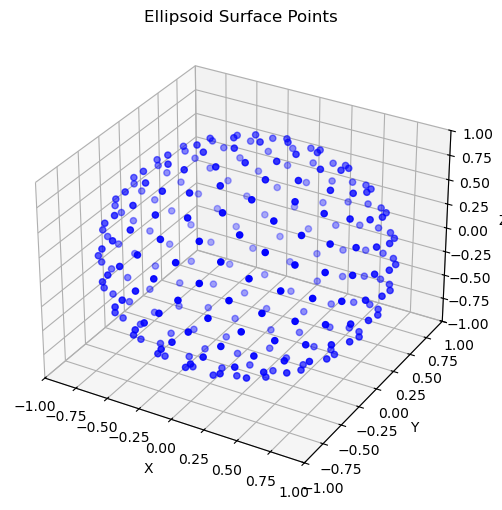

In [4]:
def plot_ellipsoid(points, a, b, c):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ellipsoid Surface Points')
    
    #set equal AR so we can actually see the shape
    max_radius = max(a, b, c)
    ax.set_xlim([-max_radius, max_radius])
    ax.set_ylim([-max_radius, max_radius])
    ax.set_zlim([-max_radius, max_radius])
    
    plt.show()

n = 250
# a = 0.01; b = 0.0075; c = 0.005
a = 1; b = 1; c = 1
phi = 0; theta = 0; psi = 0
ellipsoid_points = generate_ellipsoid(n, a, b, c)
rotated_ellipsoid_points = rotate_ellipsoid(ellipsoid_points, phi, theta, psi)
plot_ellipsoid(rotated_ellipsoid_points, a, b, c)

In [5]:
def check_unique(points, tol=1e-6):
    tree = KDTree(points)  #KD-tree for fast nearest-neighbor search
    unique_mask = np.ones(len(points), dtype=bool)  #track unique points

    for i in range(len(points)):
        if unique_mask[i]:  #"if the point is still marked as unique"
            neighbors = tree.query_ball_point(points[i], tol)  #find close points
            unique_mask[neighbors] = False  # Mark all neighbors as non-unique
            unique_mask[i] = True  #keep the first occurrence as unique

    unique_count = np.sum(unique_mask)  #remaining unique points
    total_count = len(points)
    
    return unique_count, total_count

u_count_tol, t_count_tol = check_unique(rotated_ellipsoid_points, tol=1e-6)

u_count_tol, t_count_tol

(250, 250)

In [6]:
def average_distance(points):
    tree = KDTree(points)  #KD-tree for fast nearest-neighbor search
    distances, _ = tree.query(points, k=2)  #nearest neighbor for each point
    avg_distance = np.mean(distances[:, 1])  #exclude self-distance (first column)
    return avg_distance

avg_dist1 = average_distance(rotated_ellipsoid_points)

avg_dist1

#sqrt(surface area of ellipsoid / N

0.21384131074243287

### Surface Area Using Knud Thomsen's Formula

$$ S \approx 4\pi \bigg[ \frac{a^p b^p + a^p c^p + b^p c^p}{3} \bigg]^{\frac{1}{p}}$$

where $ p \approx 1.6075$ yields a relative error of at most 1.061%

https://www.numericana.com/answer/ellipsoid.htm#thomsen

In [7]:
def knud(a, b, c, n):
    p = 1.6075
    S = 4 * np.pi * ((a**p * b**p + a**p * c**p + b**p * c**p) / 3)**(1/p)
    return np.sqrt(S / n)

avg_dist2 = knud(a, b, c, n)

def surface_area(a, b, c):
    return 4.0*np.pi*b*c*elliprg(a**2/b**2,a**2/c**2,1)

In [8]:
def S_func_ellipsoid(x, x0, eps):
    # radius = np.linalg.norm(x - x0)
    # epsilon = eps  
    # #could be missing normalization (decide after validation)
    # p1 = np.eye(3) * ((radius**2 + 2 * epsilon**2) / (radius**2 + epsilon**2)**(3/2))
    # p2 = (1 / (radius**2 + epsilon**2)**(3/2)) * np.outer(x - x0, x - x0)
    # return p1 + p2

    # Solutions derived with Wendland polynomial kernel compactly supported on the ball of radius d
    # For more details, see Evrard, Denner, van Wachem JCP (2020) and Cortez, Varela JCP (2015)
    r = np.linalg.norm(x - x0)
    d = 0.8 * eps
    if (r < d):
        H1 = -(81*r**7-400*r**6*d+735*r**5*d**2-540*r**4*d**3+168*r**2*d**5-60*d**7)/(120*np.pi*d**8)
        H2 = (21*r**5-100*r**4*d+175*r**3*d**2-120*r**2*d**3+28*d**5)/(40*np.pi*d**8)
        return H1*np.identity(3)+H2*np.outer(x - x0, x - x0)
    else:
        H1 = (15*r**2*d+d**3)/(120*np.pi*r**3*d)
        H2 = (5*r**2-d**2)/(40*np.pi*r**5)
        return H1*np.identity(3)+H2*np.outer(x - x0, x - x0)

def BuildXXandRTerms(x):
    N = len(x)
    R = np.zeros((N,N))
    XX = np.zeros((3*N,3*N))
    for i in range(N):
        for j in range(i+1,N):
            for k in range(3):
                for l in range(3):
                    XX[3*i+k][3*j+l] = (x[i][k] - x[j][k])*(x[i][l] - x[j][l])
            r = 0
            for k in range(3): r += XX[3*i+k][3*j+k]
            r = np.sqrt(r)
            R[i][j] = r
    return R + R.T, XX + XX.T

def BuildXX(x):
    N = len(x)
    R = np.zeros((N,N))
    XX = np.zeros((3*N,3*N))
    print("Building outer-product matrix")
    for i in tqdm(range(N)):
        for j in range(i+1,N):
            xx = np.outer(x[i]-x[j],x[i]-x[j])
            XX[3*i:3*i+3,3*j:3*j+3] = xx
            R[i][j] = np.trace(xx)
    R = np.sqrt(R)
    return XX + XX.T, R + R.T

def MRS_ellipsoid(n, a, b, c, phi, theta, psi):
    points = generate_ellipsoid(n, a, b, c)
    x = rotate_ellipsoid(points, phi, theta, psi)
    N = len(x)
    
    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec
    v = vel.reshape(-1, 1)

    eps = np.sqrt(surface_area(a, b, c)/N)
    M = np.zeros((3*N,3*N))
    for i in range(N):
        for j in range(N):
            M[3*i:3*i+3, 3*j:3*j+3] = S_func_ellipsoid(x[j], x[i], eps)

    F = np.linalg.solve(M, v)
    F_matrix = F.reshape(N, 3)
    Fx = np.sum(F_matrix[:, 0])
    Fy = np.sum(F_matrix[:, 1])
    Fz = np.sum(F_matrix[:, 2])
    F_vector = np.array([Fx, Fy, Fz])
    
    return x, F, F_vector

def MRS_ellipsoid_vectorized(n, a, b, c, phi, theta, psi):
    points = generate_ellipsoid(n, a, b, c)
    x = rotate_ellipsoid(points, phi, theta, psi)
    N = len(x)
    eps = np.sqrt(surface_area(a, b, c)/N)
    d = 0.8 * eps

    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec
    v = vel.reshape(-1, 1)

    XX, R = BuildXX(x)
    I = np.array(circulant(np.tile(np.array([1.0,0.0,0.0]),N))).transpose()


    H1_funct = np.vectorize(lambda r, d: -(81*r**7-400*r**6*d+735*r**5*d**2-540*r**4*d**3+168*r**2*d**5-60*d**7)/(120*np.pi*d**8) if r < d else (15*r**2*d+d**3)/(120*np.pi*r**3*d))
    H2_funct = np.vectorize(lambda r, d: (21*r**5-100*r**4*d+175*r**3*d**2-120*r**2*d**3+28*d**5)/(40*np.pi*d**8) if r < d else (5*r**2-d**2)/(40*np.pi*r**5))
    H1 = H1_funct(R,d)
    H2 = H2_funct(R,d)
    print("Building MRS matrix")
    for i in tqdm(range(N)):
        for j in range(N):
            I[3*i:3*i+3, 3*j:3*j+3] *= H1[i][j]
            XX[3*i:3*i+3, 3*j:3*j+3] *= H2[i][j]
    
    F = np.linalg.solve(I+XX, v)
    F_matrix = F.reshape(N, 3)
    Fx = np.sum(F_matrix[:, 0])
    Fy = np.sum(F_matrix[:, 1])
    Fz = np.sum(F_matrix[:, 2])
    F_vector = np.array([Fx, Fy, Fz])
    
    return x, F, F_vector

In [9]:
rotated_ellipsoid_points, F, F_vector = MRS_ellipsoid(n, a, b, c, phi, theta, psi)

N = len(rotated_ellipsoid_points)
print(np.linalg.norm(F_vector))

18.937571974107442


In [10]:
rotated_ellipsoid_points, F, F_vector = MRS_ellipsoid_vectorized(n, a, b, c, phi, theta, psi)

N = len(rotated_ellipsoid_points)
print(np.linalg.norm(F_vector))

Building outer-product matrix


100%|██████████| 250/250 [00:00<00:00, 2437.43it/s]


Building MRS matrix


100%|██████████| 250/250 [00:00<00:00, 1344.79it/s]

18.937571974107446


In [11]:
def plot_MRS_ellipsoid(rotated_ellipsoid_points, F, F_vector, a, b, c):
    N = len(rotated_ellipsoid_points)
    
    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec
    v = vel.reshape(-1, 1)
    
    Nx, Ny, Nz = 20, 20, 1  #resolution
    Ngrid = Nx * Ny * Nz

    #define domain size based on ellipsoid size
    r_ellipsoid = max(a, b, c) / 2
    x0, x1 = -3 * r_ellipsoid, 3 * r_ellipsoid
    y0, y1 = -3 * r_ellipsoid, 3 * r_ellipsoid
    #@z0, z1 = -r_ellipsoid, r_ellipsoid
    z0, z1 = 0, 1

    dx, dy, dz = (x1 - x0) / (Nx - 1), (y1 - y0) / (Ny - 1), (z1 - z0)

    fv_points = []
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                x_coord = x0 + x * dx
                y_coord = y0 + y * dy
                z_coord = z0 + z * dz
                fv_points.append([x_coord, y_coord, z_coord])
    FV_points = np.array(fv_points)

    M1 = np.zeros((3 * Ngrid, 3 * N))
    eps = np.sqrt(surface_area(a, b, c)/N)

    for i in range(Ngrid):
        for j in range(N):
            S = S_func_ellipsoid(rotated_ellipsoid_points[j], FV_points[i], eps)
            M1[3*i:3*i+3, 3*j:3*j+3] = S

    FV_vel = M1 @ F
    FV_vel_matrix = np.reshape(FV_vel, (-1, 3))

    tolerance = 0.075*a
    cross_section_points = rotated_ellipsoid_points[np.abs(rotated_ellipsoid_points[:, 2]) < tolerance]
    x_coords_cs = cross_section_points[:, 0]
    y_coords_cs = cross_section_points[:, 1]

    x_coords, y_coords, u, v = [], [], [], []
    k = 0
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                x_coord = x0 + x * dx
                y_coord = y0 + y * dy
                z_coord = z0 + z * dz
                radius = np.sqrt(x_coord**2 + y_coord**2)

                if radius > r_ellipsoid and abs(z_coord) < 0.5 * dz:
                    x_coords.append(x_coord)
                    y_coords.append(y_coord)
                    u.append(FV_vel[3 * k + 0] + u_inf) 
                    v.append(FV_vel[3 * k + 1])
                k += 1

    hull = ConvexHull(rotated_ellipsoid_points)
    hull_delaunay = Delaunay(rotated_ellipsoid_points)

    filtered_x_coords, filtered_y_coords, filtered_u, filtered_v = [], [], [], []
    k = 0
    for i in range(len(x_coords)):
        point = np.array([x_coords[i], y_coords[i], 0])
        if not hull_delaunay.find_simplex(point) >= 0:
            filtered_x_coords.append(x_coords[i])
            filtered_y_coords.append(y_coords[i])
            filtered_u.append(u[i])
            filtered_v.append(v[i])
    fig, ax = plt.subplots()
    ax.quiver(filtered_x_coords, filtered_y_coords, filtered_u, filtered_v)
    ax.scatter(x_coords_cs, y_coords_cs, color='b', marker='o')
    ax.set_xlabel('X-Axis')
    ax.set_ylabel('Y-Axis')
    ax.set_title('Filtered 2D Velocity Field Around Rotated Cube using Convex Hull')
    plt.show()

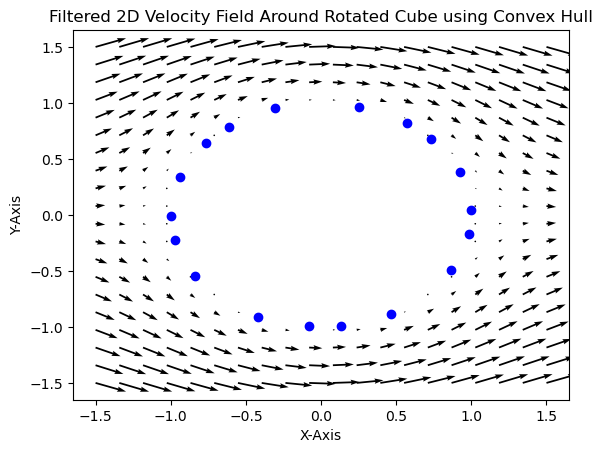

In [12]:
plot_MRS_ellipsoid(rotated_ellipsoid_points, F, F_vector, a, b, c)

## Validation

Brenner 1983 (PDF 168, Book 155) [EQN (4-30.8)]

$$ F_z = -\frac{8 \pi \mu c U}{(\tau_0^2 +1)coth^{-1}(\tau_0) - \tau_0} $$

where $c=\sqrt{a^2 - b^2}$, $a$ and $b$ are the polar and equatorial radii, $\tau_0$ is:
$$ \tau_0 = \frac{a}{c} = \Big[1- \big(\frac{b}{a} \big)^2 \Big]^{-1/2}$$

In [14]:
pow_list = np.linspace(1,3.5,10)
n1_list = (10**pow_list).astype(int)
a1 = 0.01; b1 = 0.005; c1 = 0.005
phi1 = 0; theta1 = 0; psi1 = 0
mu1 = 1.0
U1 = 1.0
U0 = np.array([-U1, 0, 0])

def brenner_fz(mu, U, a, b):
    c_= np.sqrt(a**2 - b**2)
    tau_0 = a / c_
    tau_0 = (1 - (b / a)**2 )**(-1/2)
    denominator = (tau_0**2 + 1) * np.arctanh(1 / tau_0) - tau_0
    numerator = 8 * np.pi * mu * c_ * U
    
    return -numerator/denominator

F1_list = []; Error_list = []
for n1 in n1_list:
  print("Calculating MRS solution with", n1, "points")
  points1, F1, F_vector1 = MRS_ellipsoid_vectorized(n1, a1, b1, c1, phi1, theta1, psi1)
  print("Force = ", F_vector1)
  err = np.linalg.norm(F_vector1-np.array([brenner_fz(mu1, U1, a1, b1), 0, 0]))
  Error_list.append(err)
  print("Error = {:.2e}".format(err))
  F1_list.append(F_vector1)

Calculating MRS solution with 10 points
Building outer-product matrix


100%|██████████| 10/10 [00:00<00:00, 16100.98it/s]


Building MRS matrix


100%|██████████| 10/10 [00:00<00:00, 16474.09it/s]


Force =  [-1.18549438e-01  1.12133929e-04  8.87879161e-04]
Error = 5.16e-03
Calculating MRS solution with 18 points
Building outer-product matrix


100%|██████████| 18/18 [00:00<00:00, 12595.51it/s]


Building MRS matrix


100%|██████████| 18/18 [00:00<00:00, 7226.71it/s]


Force =  [-0.11776381  0.00016625 -0.00014144]
Error = 4.30e-03
Calculating MRS solution with 35 points
Building outer-product matrix


100%|██████████| 35/35 [00:00<00:00, 7828.11it/s]


Building MRS matrix


100%|██████████| 35/35 [00:00<00:00, 1919.79it/s]


Force =  [-1.16787696e-01  4.55837253e-05 -1.34173380e-04]
Error = 3.32e-03
Calculating MRS solution with 68 points
Building outer-product matrix


100%|██████████| 68/68 [00:00<00:00, 2378.46it/s]


Building MRS matrix


100%|██████████| 68/68 [00:00<00:00, 3017.26it/s]

Force =  [-1.15804590e-01 -1.67314174e-05 -1.86734167e-05]
Error = 2.34e-03
Calculating MRS solution with 129 points


Building outer-product matrix


100%|██████████| 129/129 [00:00<00:00, 1478.05it/s]


Building MRS matrix


100%|██████████| 129/129 [00:00<00:00, 1219.27it/s]


Force =  [-1.15129931e-01  1.87064768e-05 -2.87352925e-06]
Error = 1.66e-03
Calculating MRS solution with 244 points
Building outer-product matrix


100%|██████████| 244/244 [00:00<00:00, 1329.80it/s]


Building MRS matrix


100%|██████████| 244/244 [00:00<00:00, 1323.97it/s]


Force =  [-1.14620559e-01  1.78618109e-05 -8.96887881e-07]
Error = 1.15e-03
Calculating MRS solution with 464 points
Building outer-product matrix


100%|██████████| 464/464 [00:00<00:00, 888.25it/s]


Building MRS matrix


100%|██████████| 464/464 [00:00<00:00, 721.66it/s]


Force =  [-1.14271730e-01  2.22165644e-06  8.85562759e-08]
Error = 8.03e-04
Calculating MRS solution with 879 points
Building outer-product matrix


100%|██████████| 879/879 [00:01<00:00, 527.36it/s]


Building MRS matrix


100%|██████████| 879/879 [00:02<00:00, 351.28it/s]


Force =  [-1.14029781e-01  4.45702040e-07 -2.84175265e-07]
Error = 5.61e-04
Calculating MRS solution with 1668 points
Building outer-product matrix


100%|██████████| 1668/1668 [00:04<00:00, 359.08it/s]


Building MRS matrix


100%|██████████| 1668/1668 [00:09<00:00, 184.74it/s]


Force =  [-1.13861388e-01  1.85649365e-08 -1.01921302e-07]
Error = 3.93e-04
Calculating MRS solution with 3162 points
Building outer-product matrix


100%|██████████| 3162/3162 [00:16<00:00, 190.45it/s] 


Building MRS matrix


100%|██████████| 3162/3162 [00:32<00:00, 97.34it/s] 


Force =  [-1.13745520e-01  1.42710348e-07 -1.59054114e-08]
Error = 2.77e-04


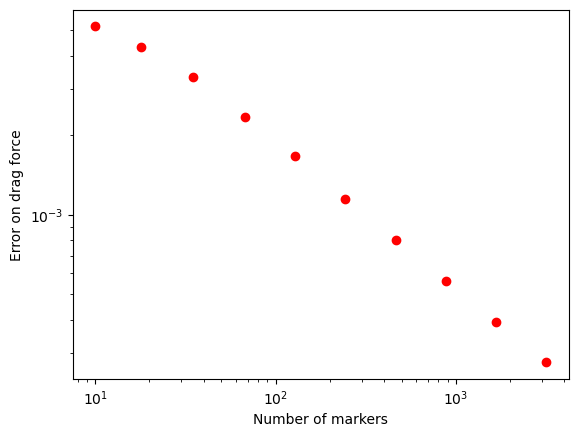

In [15]:
plt.loglog(n1_list,Error_list,"ro")
plt.xlabel('Number of markers')
plt.ylabel('Error on drag force')
plt.show()